Showing the main code's outputs with jupyter notebook. (Univariate)

## Data Preparation

In [1]:
# Forecasting TOYOTA's Earnings

# importing external packages
import sys
import os
import datetime
import numpy as np
import pandas as pd
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import warnings

warnings.simplefilter("ignore")

# importing internal modules
sys.path.insert(1, '../')

from src.models.sarima_univariate import rolling_window
from src.models.nn import MLP
from src.utils.accuracy import *

In [2]:
# run data_preprocessing.py file to generate data
os.system("python data_preprocessing.py")

# read cleaned data generated from data_preprocessing.py
data_path = "../data/processed/dataset.csv"
ts = pd.read_csv(data_path, index_col=0)

ts.head()

,決算期,決算発表日,決算月数,売上高・営業収益,売上総利益,営業利益,経常利益／税金等調整前当期純利益,当期純利益（連結）,１株当たり利益,販売費及び一般管理費,棚卸資産,資本的支出,期末従業員数,受取手形・売掛金／売掛金及びその他の短期債権
0,2002-06-01,2002-08-07,3.0,4021134.0,980461.0,394518.0,449936.0,NaN,100.80,585942.0,960431.0,1178647.5,247128.428571,1292182.0
1,2002-09-01,2002-12-26,6.0,3592288.0,840121.0,290505.0,264525.0,NaN,17.64,549617.0,927040.0,808702.0,250809.142857,1245733.0
2,2002-12-01,2003-02-05,9.0,4460037.0,1016004.0,425241.0,449835.0,NaN,103.23,636567.0,1042173.0,1209465.5,254489.857143,1339274.0
3,2003-03-01,2003-07-31,12.0,3428094.0,750722.0,161382.0,62356.0,NaN,-10.35,543536.0,1025838.0,1610229.0,258170.571429,1475797.0
4,2003-06-01,2003-08-05,3.0,4092939.0,953636.0,340772.0,371279.0,NaN,64.83,612864.0,1054208.0,1177102.5,261851.285714,1335846.0


In [3]:
ts.describe()

,決算月数,売上高・営業収益,売上総利益,営業利益,経常利益／税金等調整前当期純利益,当期純利益（連結）,１株当たり利益,販売費及び一般管理費,棚卸資産,資本的支出,期末従業員数,受取手形・売掛金／売掛金及びその他の短期債権
count,72.00000,7.200000e+01,7.200000e+01,72.000000,72.000000,40.000000,72.000000,72.000000,7.200000e+01,7.200000e+01,72.000000,7.200000e+01
mean,7.50000,5.836196e+06,1.234343e+06,417093.291667,441065.194444,432300.975000,106.586667,640030.277778,1.778624e+06,1.789671e+06,321806.469246,1.775406e+06
std,3.37764,1.254573e+06,4.020260e+05,272623.620006,308570.634446,240375.202714,83.872018,161500.685891,4.834236e+05,9.748059e+05,36826.237848,2.919907e+05
min,3.00000,3.428094e+06,1.267540e+05,-682528.000000,-914729.000000,2859.000000,-243.790000,-161682.000000,9.270400e+05,3.699280e+05,247128.428571,1.245733e+06
25%,5.25000,4.773247e+06,9.443628e+05,328081.500000,256171.500000,208711.500000,57.770000,548096.750000,1.415543e+06,1.037258e+06,297267.750000,1.500211e+06
50%,7.50000,5.906180e+06,1.269906e+06,443770.500000,461741.500000,482949.500000,103.970000,646305.000000,1.812280e+06,1.576169e+06,323936.000000,1.807128e+06
75%,9.75000,7.002638e+06,1.577830e+06,600771.250000,643152.500000,614472.250000,160.855000,731498.500000,2.111988e+06,2.271390e+06,349225.250000,2.003336e+06
max,12.00000,7.801542e+06,2.004790e+06,827404.000000,893960.000000,970686.000000,318.400000,942763.000000,2.656396e+06,5.121960e+06,379201.000000,2.389104e+06


In [4]:
# y
var_name = "１株当たり利益"

y = ts[var_name]

# train test split (4/5) : (1/5), yearly bases
test_size = (len(y) // 5) + (len(y) // 5) % 4
train_size = len(y) -test_size
y_train = y[:-test_size]
y_test = y[-test_size:]

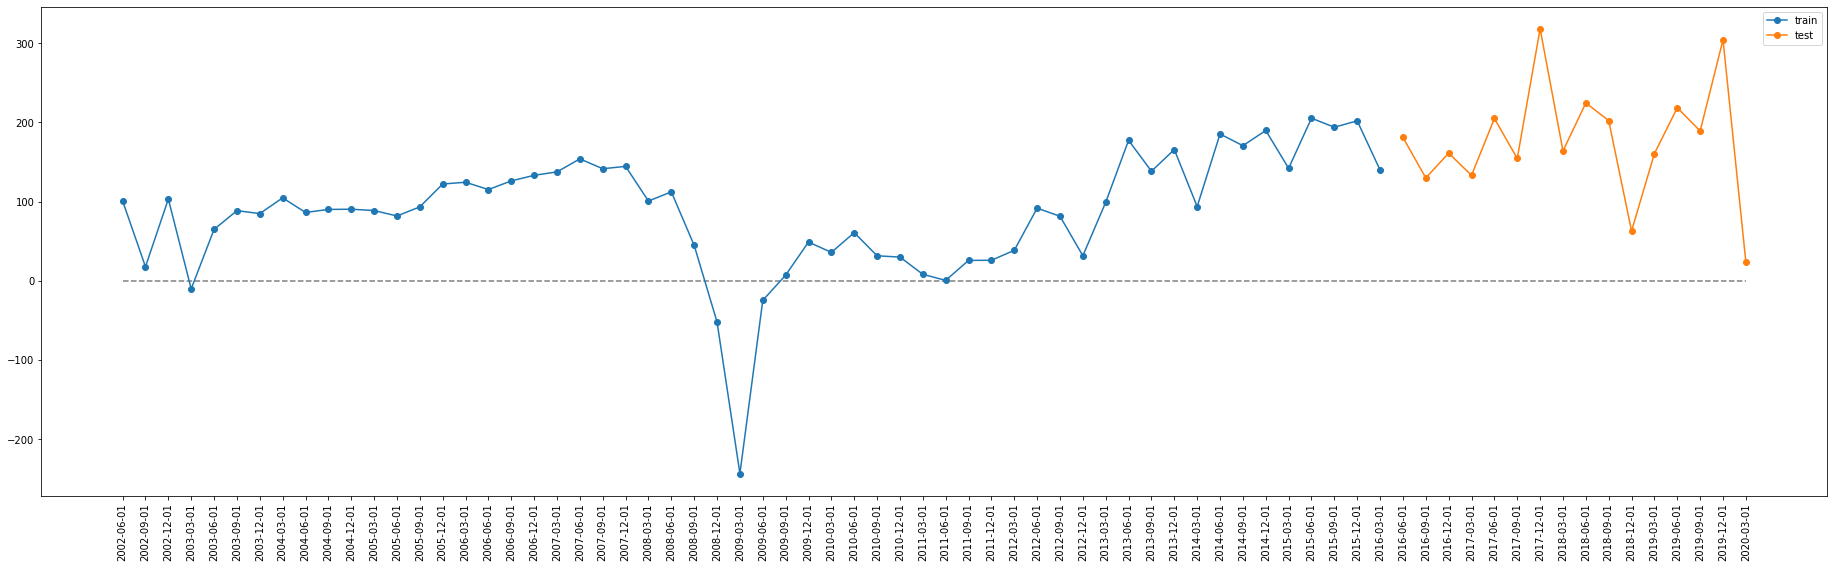

In [5]:
# plot
fig = plt.figure(figsize=(16*2, 9))
ax = fig.add_subplot(111)

ax.plot(ts["決算期"], [0] * len(ts["決算期"]), color="gray", linestyle="--")
#ax.plot(ts["決算期"], y, marker="o", label="record")
ax.plot(ts["決算期"][:-test_size], y_train, marker="o", label="train")
ax.plot(ts["決算期"][-test_size:], y_test, marker="o", label="test")

ax.tick_params(axis="x", rotation=90)
ax.legend()
plt.show()

## Model Estimation

### Random walk

In [6]:
# random walk
y_hat_rw = y.shift(1)[-test_size:]
y_hat_rw

56    139.92
57    181.12
58    129.96
59    161.23
60    133.16
61    205.05
62    154.50
63    318.40
64    164.05
65    224.67
66    202.35
67     62.80
68    160.73
69    218.62
70    189.28
71    304.56
Name: １株当たり利益, dtype: float64

### SARIMA: Brown & Rozeff
$ (p, d, q) \times (P, D, Q)_S = (1, 0, 0) \times (0, 1, 1)_4 $

In [7]:
# SARIMA: Brown & Rozeff
y_hat_sarima_br = rolling_window(
    window = train_size,
    prim_train=y_train,
    test=y_test,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 4),
    silent=True
)
y_hat_sarima_br

56    168.914835
57    150.406376
58    124.326164
59    129.916281
60    137.030421
61    138.992681
62    146.053754
63    225.987982
64    178.259869
65    192.204979
66    186.298340
67    108.091089
68    140.578074
69    122.198341
70    140.828753
71    148.226916
dtype: float64

### SARIMA: Griffin
$ (p, d, q) \times (P, D, Q)_S = (0, 1, 1) \times (0, 1, 1)_4 $

In [8]:
# SARIMA: Griffin
y_hat_sarima_g = rolling_window(
    window = train_size,
    prim_train=y_train,
    test=y_test,
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, 4),
    silent=True
)
y_hat_sarima_g

56    188.633585
57    174.999444
58    151.919157
59    165.634456
60    181.190423
61    197.892464
62    177.373079
63    329.341877
64    254.139553
65    243.246725
66    242.172804
67     96.255873
68    200.954300
69    204.468707
70    222.991161
71    322.657621
dtype: float64

### SARIMA: Foster
$ (p, d, q) \times (P, D, Q)_S = (1, 0, 0) \times (0, 1, 0)_4 $

In [9]:
# SARIMA: Foster
y_hat_sarima_f = rolling_window(
    window = train_size,
    prim_train=y_train,
    test=y_test,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 0, 4),
    silent=True
)
y_hat_sarima_f

56    204.072833
57    192.460582
58    164.029506
59    153.934639
60    175.742317
61    173.905227
62    213.726573
63    358.088167
64    229.028899
65    328.227763
66    240.275692
67     21.939324
68    222.800642
69     61.032536
70    216.625833
71    322.612352
dtype: float64

### Simple 3 layers Multi Layer Perceptron

In [10]:
# 3 Layers Feed Forward Neural Network
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! rolling, expanding window are not implemented yet !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# y, x (lag 4)
y = ts[var_name].drop([0, 1, 2, 3], axis=0)
y = y.reset_index(drop=True)

x = pd.DataFrame([
    ts[var_name].shift(1),
    ts[var_name].shift(2),
    ts[var_name].shift(3),
    ts[var_name].shift(4),
]).T.drop([0, 1, 2, 3], axis=0)
x = x.reset_index(drop=True)
x.columns = ["y_(t-1)", "y_(t-2)", "y_(t-3)", "y_(t-4)"]

y

0      64.83
1      88.53
2      84.83
3     104.71
4      86.24
       ...  
63    160.73
64    218.62
65    189.28
66    304.56
67     23.15
Name: １株当たり利益, Length: 68, dtype: float64

In [11]:
x.head()

,y_(t-1),y_(t-2),y_(t-3),y_(t-4)
0,-10.35,103.23,17.64,100.80
1,64.83,-10.35,103.23,17.64
2,88.53,64.83,-10.35,103.23
3,84.83,88.53,64.83,-10.35
4,104.71,84.83,88.53,64.83


In [12]:
# Convert data type to torch.tensor
dtype = torch.float
device = torch.device("cpu")

y_tensor = torch.tensor(y.values, dtype=dtype)
x_tensor = torch.tensor(x.values, dtype=dtype)

y_tensor.size(), x_tensor.size()

(torch.Size([68]), torch.Size([68, 4]))

In [13]:
# train test split
y_test_tensor = y_tensor[-test_size:]
y_train_tensor = y_tensor[:-test_size]

x_test_tensor = x_tensor[-test_size:]
x_train_tensor = x_tensor[:-test_size]

print(y_train_tensor.size(), y_test_tensor.size())
print(x_train_tensor.size(), x_test_tensor.size())

torch.Size([52]) torch.Size([16])
torch.Size([52, 4]) torch.Size([16, 4])


In [14]:
# set RNG seed
torch.manual_seed(1)

# construct, instantiate MLP
mlp = MLP(input_features=4, hidden_units=100, output_units=1)
mlp

MLP(
  (hidden): Linear(in_features=4, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
)

In [15]:
# Access to mlp weights
# Initial parameters (weights, bias)
list(mlp.parameters()) # iteretor, just for printing

[Parameter containing:
 tensor([[ 0.2576, -0.2207, -0.0969,  0.2347],
         [-0.4707,  0.2999, -0.1029,  0.2544],
         [ 0.0695, -0.0612,  0.1387,  0.0247],
         [ 0.1826, -0.1949, -0.0365, -0.0450],
         [ 0.0725, -0.0020,  0.4371,  0.1556],
         [-0.1862, -0.3020, -0.0838, -0.2157],
         [-0.1602,  0.0239,  0.2981,  0.2718],
         [-0.4888,  0.3100,  0.1397,  0.4743],
         [ 0.3300, -0.4556, -0.4754, -0.2412],
         [ 0.4391, -0.0833,  0.2140, -0.2324],
         [ 0.4906, -0.2115,  0.3750,  0.0059],
         [-0.2634,  0.2570, -0.2654,  0.1471],
         [-0.1444, -0.0548, -0.4807, -0.2384],
         [ 0.2713, -0.1215,  0.4980,  0.4008],
         [-0.0234, -0.3337,  0.3045,  0.1552],
         [-0.3232,  0.3248,  0.3036,  0.4434],
         [-0.2803, -0.0823, -0.0097,  0.0730],
         [-0.3795, -0.3548,  0.2720, -0.1172],
         [ 0.2442,  0.0285,  0.1642,  0.1099],
         [ 0.1818,  0.2479, -0.4631,  0.2517],
         [-0.3516, -0.3773,  0.0304, 

In [16]:
print(mlp.hidden.weight.size(), mlp.hidden.bias.size()) # editable ?
print(mlp.output.weight.size(), mlp.output.bias.size())

torch.Size([100, 4]) torch.Size([100])
torch.Size([1, 100]) torch.Size([1])


In [17]:
# Construct loss and optimizer
criterion = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-2) # link to mlp parameters

In [18]:
criterion

MSELoss()

In [19]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [20]:
# Learning iteration
num_iteration = 10000

for step in range(num_iteration):
    # Forward pass
    y_pred = mlp(x_train_tensor)
    # let y_pred be the same size as y
    y_pred = y_pred.squeeze(1)

    # Compute loss
    loss = criterion(y_pred, y_train_tensor) # link to mlp output
    if step % 1000 == 999:
        print(f"step {step}: loss {loss.item()}")

    # Zero gradients, perform backward pass, and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

step 999: loss 1268.3673095703125
step 1999: loss 514.0156860351562
step 2999: loss 194.39878845214844
step 3999: loss 71.26213836669922
step 4999: loss 43.88747787475586
step 5999: loss 30.07744026184082
step 6999: loss 20.23455047607422
step 7999: loss 19.294416427612305
step 8999: loss 13.529149055480957
step 9999: loss 11.314294815063477


In [21]:
# Check trained parameters
list(mlp.parameters())

[Parameter containing:
 tensor([[ 8.3694e-01,  3.6191e-02, -2.9272e-01,  5.7951e-01],
         [-1.1313e+00,  1.0871e+00, -9.8852e-01,  2.1064e-01],
         [ 4.8308e-01, -1.2548e+00, -5.2249e-01,  9.7533e-01],
         [ 6.7270e-01, -1.3870e+00,  3.8486e-01, -5.5486e-02],
         [ 1.3378e+00, -4.4044e-01,  8.3763e-01, -2.1407e-01],
         [ 3.2510e-01,  1.8902e-01, -1.5347e-01, -1.0658e+00],
         [-6.8214e-04,  2.2322e-01,  3.8580e-01,  9.4113e-01],
         [-9.4053e-01,  2.4365e-01,  7.7483e-01,  6.7509e-01],
         [ 1.0261e+00, -5.4144e-01,  5.2462e-01,  5.5791e-02],
         [ 6.1839e-01, -1.2492e+00,  1.1539e+00,  2.3503e-01],
         [-9.5721e-02,  3.1567e-01,  1.7281e-02, -1.1325e-01],
         [-6.3714e-01,  2.7327e-01,  8.0096e-01,  3.3952e-01],
         [ 1.3397e-01,  8.3954e-01, -1.7721e+00, -7.2772e-01],
         [ 5.4039e-01,  1.8893e-01,  3.2780e-01,  3.3287e-01],
         [ 2.0261e-02, -3.3065e-01,  1.3419e+00,  5.3460e-01],
         [-4.7400e-01,  1.3215e-

In [22]:
# predict y_hat
y_hat_mlp = mlp(x_test_tensor).squeeze().detach().numpy()
y_hat_mlp

array([158.68019 , 175.49635 , 170.46222 ,  93.029526, 134.03215 ,
       152.46564 , 211.71498 , 147.40782 , 152.47578 , 113.08425 ,
       141.64531 ,  61.268604,  45.159195, 122.708405, 122.75116 ,
       161.8203  ], dtype=float32)

## Predition Performance

In [23]:
# compare prediction performance with forecast accuracy indexes
accuracy = pd.DataFrame(
    [
        [
            MAE(y_test, y_hat_rw),
            MAE(y_test, y_hat_sarima_br),
            MAE(y_test, y_hat_sarima_g),
            MAE(y_test, y_hat_sarima_f),
            MAE(y_test, y_hat_mlp)
        ],
        [
            MAPE(y_test, y_hat_rw),
            MAPE(y_test, y_hat_sarima_br),
            MAPE(y_test, y_hat_sarima_g),
            MAPE(y_test, y_hat_sarima_f),
            MAPE(y_test, y_hat_mlp)
        ],
        [
            MSE(y_test, y_hat_rw),
            MSE(y_test, y_hat_sarima_br),
            MSE(y_test, y_hat_sarima_g),
            MSE(y_test, y_hat_sarima_f),
            MSE(y_test, y_hat_mlp)
        ],
        [
            RMSE(y_test, y_hat_rw),
            RMSE(y_test, y_hat_sarima_br),
            RMSE(y_test, y_hat_sarima_g),
            RMSE(y_test, y_hat_sarima_f),
            RMSE(y_test, y_hat_mlp)
        ],
        [
            RMSPE(y_test, y_hat_rw),
            RMSPE(y_test, y_hat_sarima_br),
            RMSPE(y_test, y_hat_sarima_g),
            RMSPE(y_test, y_hat_sarima_f),
            RMSPE(y_test, y_hat_mlp)
        ]
    ],
    index=["MAE", "MAPE", "MSE", "RMSE", "RMSPE"],
    columns=["random walk", "SARIMA: BR", "SARIMA: G", "SARIMA: F", "MLP"]
)
accuracy

,random walk,SARIMA: BR,SARIMA: G,SARIMA: F,MLP
MAE,87.295625,66.077148,74.753328,88.923733,75.874780
MAPE,1.207818,0.689469,1.218414,1.300829,0.749869
MSE,12151.358681,7104.267580,11791.377932,14700.944361,8567.061686
RMSE,110.233201,84.286817,108.588111,121.247451,92.558423
RMSPE,3.113151,1.466094,3.329172,3.343005,1.575647


## Visualize Preditctions

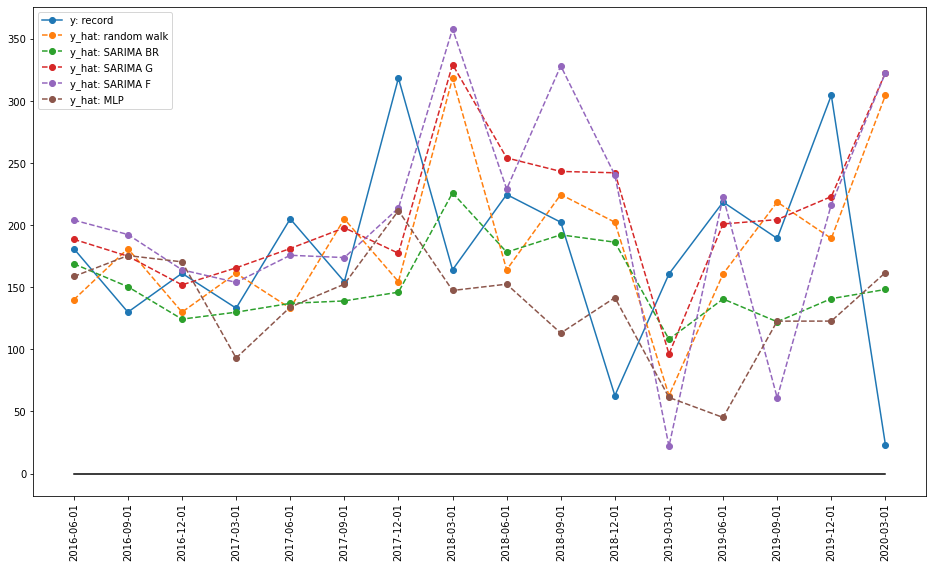

In [24]:
# plot each y_hat series
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.plot(ts["決算期"][train_size:], [0] * len(ts["決算期"][train_size:]), color="black")

ax.plot(ts["決算期"][train_size:], y_test, marker="o", label="y: record")
    

ax.plot(ts["決算期"][train_size:], y_hat_rw, marker="o", label="y_hat: random walk", linestyle="--")
ax.plot(ts["決算期"][train_size:], y_hat_sarima_br, marker="o", label="y_hat: SARIMA BR", linestyle="--")
ax.plot(ts["決算期"][train_size:], y_hat_sarima_g, marker="o", label="y_hat: SARIMA G", linestyle="--")
ax.plot(ts["決算期"][train_size:], y_hat_sarima_f, marker="o", label="y_hat: SARIMA F", linestyle="--")
ax.plot(ts["決算期"][train_size:], y_hat_mlp, marker="o", label="y_hat: MLP", linestyle="--")

ax.tick_params(axis="x", rotation=90)
ax.legend()
plt.show()